# Text Extraction with different libraries

#### Author: Sandipan Dey

## Text Extraction with Tesseract

In [199]:
import cv2
import numpy as np
import pytesseract
import re
import matplotlib.pylab as plt

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def get_text_conf(path, thres=80, rsz_factor=1, annotate=False):
    
    image = cv2.imread(path)
    
    #sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    #image = cv2.filter2D(image, -1, sharpen_filter)
    
    if rsz_factor != 1:
        image = cv2.resize(image, None, fx=rsz_factor, fy=rsz_factor, interpolation = cv2.INTER_AREA)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    txt = pytesseract.image_to_string(gray)
    txt = re.sub(r'\r\n', '\n', txt).strip()
    txt = re.sub(r'\s+\n', '\n', txt).strip()
    txt = re.sub(r'\n+', '\n', txt).strip() #cv2.equalizeHist(gray)
    
    text = pytesseract.image_to_data(gray, output_type='data.frame')
    text = text[text.conf != -1]
    
    lines = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['text'].apply(lambda x: ' '.join(list(x))).tolist()
    confs = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['conf'].mean().tolist()
    
    line_conf = []
    
    for i in range(len(lines)):
        if lines[i].strip() and confs[i] >= thres:
            line_conf.append((lines[i], round(confs[i],3)))
    
    if annotate:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        n_boxes, texts = len(text['level']), text['text'].tolist()
        left, top, width, height = text['left'].tolist(), text['top'].tolist(), text['width'].tolist(), text['height'].tolist()
        conf = text['conf'].tolist()
        for i in range(n_boxes):
            if conf[i] < thres:
                continue
            (x, y, w, h) = (left[i], top[i], width[i], height[i])
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, texts[i], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2)
        plt.figure(figsize=(20,40))
        plt.imshow(image)
        plt.show()

    return line_conf

<div>
<img src="bill.png" width="500"/>
</div>

In [200]:
get_text_conf('bill.png')

[('Ying Thai Kitchen', 91.667),
 ('2220 Queen Anne AVE N', 88.2),
 ('Seattle WA 98109', 90.333),
 ('« (206) 285-8424 Fax. (206) 285-8427', 83.167),
 ('Welcome to Ying Thai Kitchen Restaurant,', 85.333),
 ('Order#:17 Table 2', 94.0),
 ('Date: 7/4/2013 7:28 PM', 86.25),
 ('Server: Jack (1.4)', 83.0),
 ('44 Ginger Lover $9.50', 89.0),
 ('Brown Rice $2.00', 95.333),
 ('Total 2 iten(s) $11.50', 89.5),
 ('Sales Tax $1.09', 95.667),
 ('Grand Total $12.59', 95.0),
 ('Tip Guide', 95.0),
 ('Thank you very much,', 90.75),
 ('Cone back again', 92.667)]

<div>
<img src="aadhaar.jpg" width="800"/>
</div>

In [201]:
get_text_conf('aadhaar.jpg')

[('Name XXXX', 92.5),
 ('DOB: XX-XX-XXXX', 90.0),
 ('Gender: MALE', 96.0),
 ('0000 1111 2222', 94.667)]

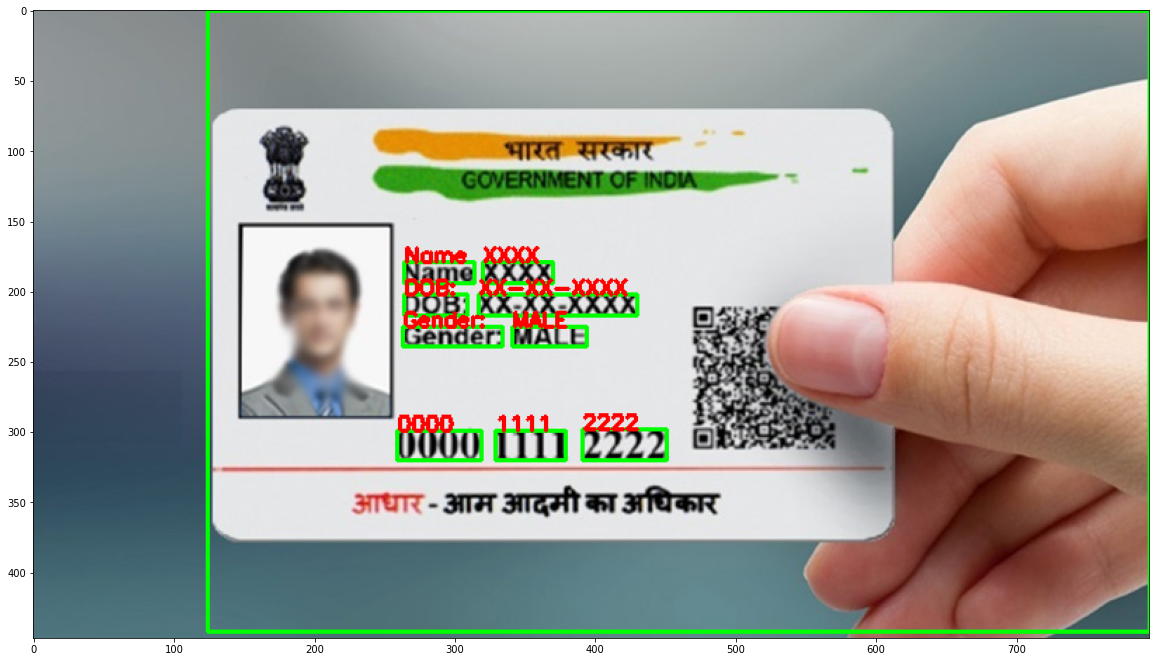

[('Name XXXX', 92.5),
 ('DOB: XX-XX-XXXX', 90.0),
 ('Gender: MALE', 96.0),
 ('0000 1111 2222', 94.667)]

In [202]:
get_text_conf('aadhaar.jpg', annotate=True)

### Extract key-value pairs with regex templates

In [139]:
import re

def process_template(keys, regex_pattern_templates, txt_conf):
    vals = {}
    for txt, conf in txt_conf:
        for k, pat in zip(keys, regex_pattern_templates):
            m = re.search(pat, txt, re.IGNORECASE | re.DOTALL)
            if m: 
                vals[k] = (m.group(1), conf)
                break
    return vals            

keys = ['Name', 'DOB', 'Gender']
regex_pattern_templates = [r'name[\s:]?\s+(.*)', 
                           r'dob[\s:]?\s+(.*)',
                          r'gender[\s:]?\s+(.*)']
tc = get_text_conf('aadhaar.jpg')
process_template(keys, regex_pattern_templates, tc)

{'Name': ('XXXX', 92.5), 'DOB': ('XX-XX-XXXX', 90.0), 'Gender': ('MALE', 96.0)}

In [141]:
def get_text_conf_regex(path, thres=80, rsz_factor=1, process_template_func=process_template):
    
    image = cv2.imread(path)
    
    #sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    #image = cv2.filter2D(image, -1, sharpen_filter)
    
    if rsz_factor != 1:
        image = cv2.resize(image, None, fx=rsz_factor, fy=rsz_factor, interpolation = cv2.INTER_AREA)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    txt = pytesseract.image_to_string(gray)
    txt = re.sub(r'\r\n', '\n', txt).strip()
    txt = re.sub(r'\s+\n', '\n', txt).strip()
    txt = re.sub(r'\n+', '\n', txt).strip() #cv2.equalizeHist(gray)
    
    text = pytesseract.image_to_data(gray, output_type='data.frame')
    text = text[text.conf != -1]
    
    lines = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['text'].apply(lambda x: ' '.join(list(x))).tolist()
    confs = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['conf'].mean().tolist()
    
    line_conf = []
    
    for i in range(len(lines)):
        if lines[i].strip() and confs[i] >= thres:
            line_conf.append((lines[i], round(confs[i],3)))
            
    line_conf = process_template_func(keys, regex_pattern_templates, line_conf)

    return line_conf

In [143]:
keys = ['Name', 'DOB', 'Gender']
regex_pattern_templates = [r'name[\s:]?\s+(.*)', 
                           r'dob[\s:]?\s+(.*)',
                          r'gender[\s:]?\s+(.*)']
get_text_conf_regex('aadhaar.jpg')

{'Name': ('XXXX', 92.5), 'DOB': ('XX-XX-XXXX', 90.0), 'Gender': ('MALE', 96.0)}

### Challenging examples

<div>
<img src="adhar2.jpg" width="800"/>
</div>

In [131]:
get_text_conf('adhar2.jpg')

[]

<div>
<img src="PanCard.png" width="400"/>
</div>

In [126]:
get_text_conf('PANCard.png', rsz_factor=2.7)

[('“FIRST NAME. MIDDLE NAME SURNAME', 85.2)]

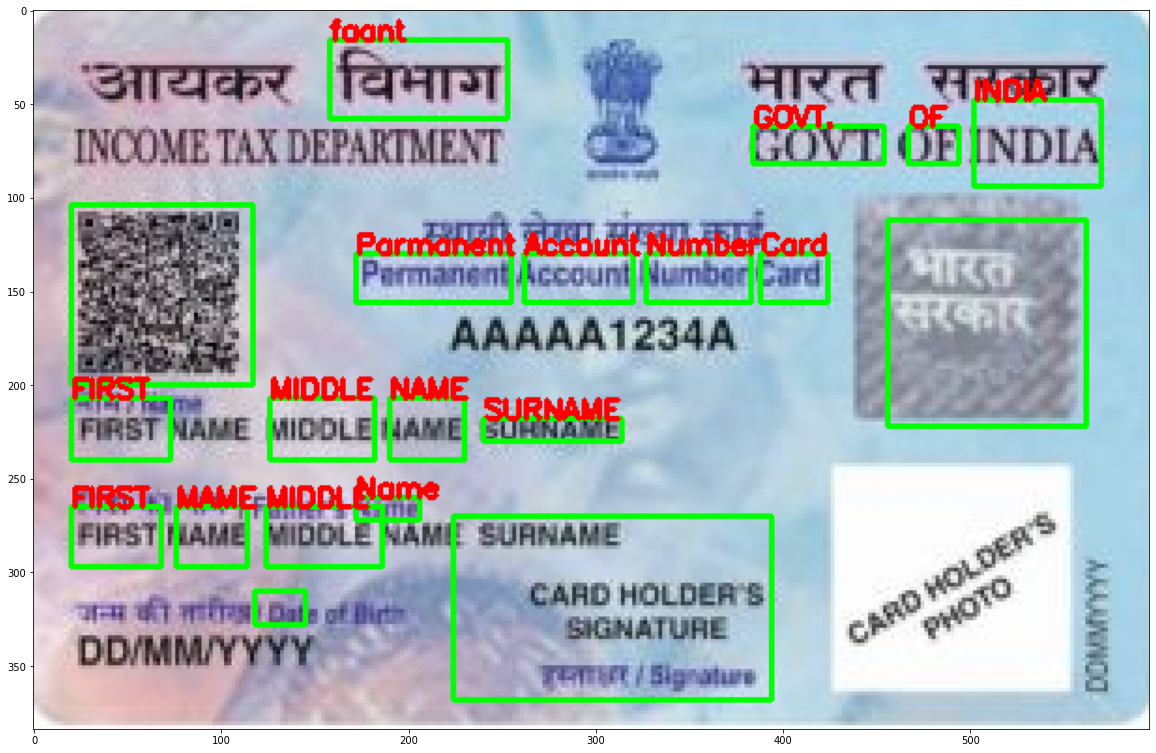

[('~INCOMETAX DEPARTMENT © = GOVT. OF INDIA', 62.0),
 ('Parmanent Account Number Card 1', 81.6),
 ('FIRST MIDDLE NAME SURNAME', 94.0),
 ('FIRST MAME MIDDLE e', 73.75)]

In [203]:
get_text_conf('PANCard.png', rsz_factor=2, thres=60, annotate=True)

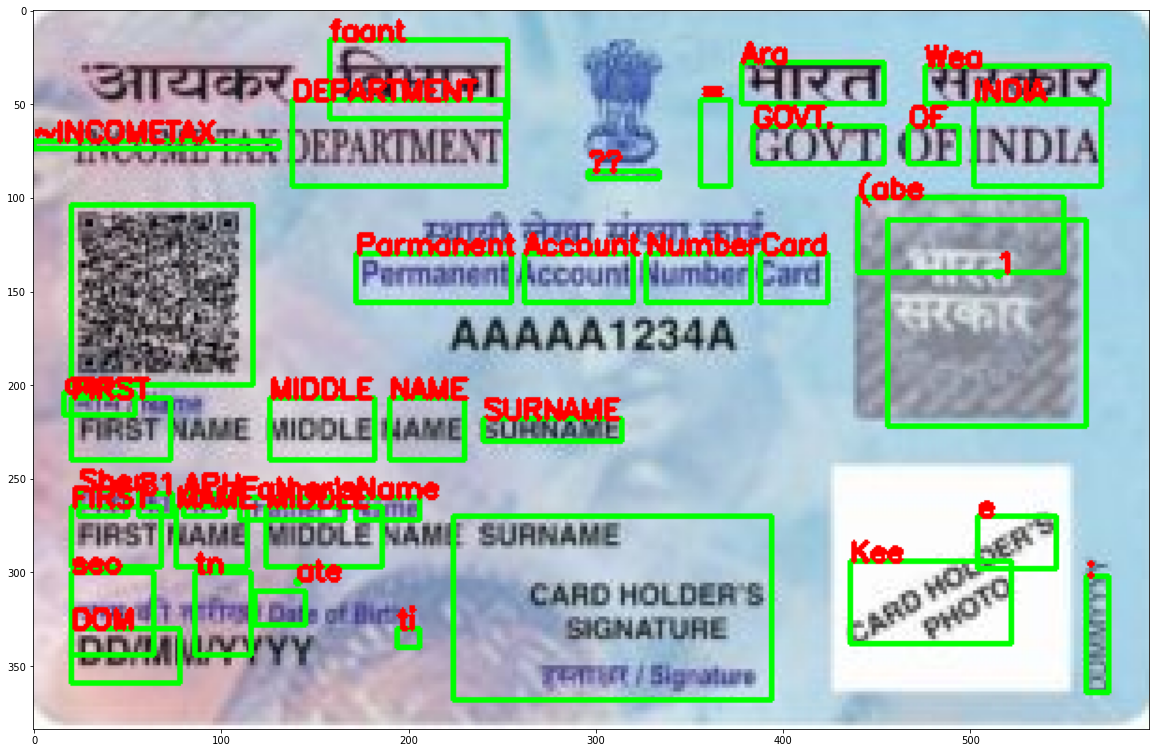

[(', Sreear faant Ara Wea', 25.8),
 ('~INCOMETAX DEPARTMENT © = GOVT. OF INDIA', 62.0),
 ('amiaendemert (abe', 12.5),
 ('Parmanent Account Number Card 1', 81.6),
 ('am', 45.0),
 ('FIRST MIDDLE NAME SURNAME', 94.0),
 ("Sher 81 APH Father's Name", 45.0),
 ('FIRST MAME MIDDLE e', 73.75),
 ('seo tn ate ti Kee :', 39.0)]

In [207]:
get_text_conf('PANCard.png', rsz_factor=2, thres=10, annotate=True)

In [128]:
get_text_conf('PANCard.png', rsz_factor=1.5)

[('Permanent Account Number Card', 93.5)]

In [129]:
get_text_conf('PANCard.png')

[]

<div>
<img src="adharapp.jpg" width="800"/>
</div>

In [209]:
get_text_conf('adharapp.jpg')

[('‘Under Section 3 of THE AADHAAR (TARGETED DELIVERY OF FINANCIAL AND OTHER SUBSIDIES, BENEFITS AND SERVICES) ACT, 2016 (Aadhaar Act) ZAN',
  93.762),
 ('AADHAAR ENROLMENT / CORRECTION FORM AADHAAR', 92.333),
 ('Aadhaar Enrolment is free and voluntary. Correction within 96 hours of enrolment is also free. No charges are applicable for Form',
  95.524),
 ('and Aadhaar Enrolment. In case of Correction provide your EID, Name and only that field which needs Correction.',
  95.389),
 ('In case of Correction provide your EID No here: 0008125412587 0 28 04 2011 15 3519',
  91.062),
 ('Please follow the instructions overleaf while filling up the form. Use capital letters only.',
  96.071),
 ('3 | FullName: SUMIT TRIBEDI k', 80.833),
 ('House No/ Bldg./Apt. 123 Street/Road/Lane K.G.R. PATH', 83.143),
 ('Village/Town/City KANCHRAPARA Post Office KANCHRAPARA', 93.2),
 ('District NORTH 24 PGS Sub-District State WEST BENGAL', 94.375)]

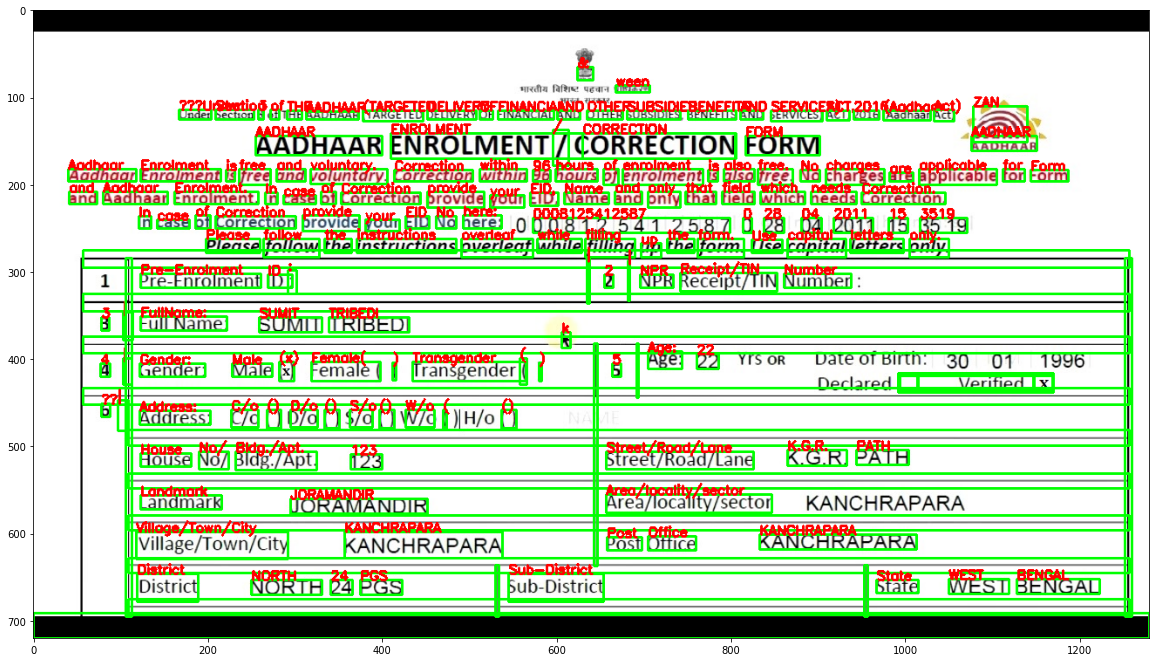

[('&', 52.0),
 ('‘Under Section 3 of THE AADHAAR (TARGETED DELIVERY OF FINANCIAL AND OTHER SUBSIDIES, BENEFITS AND SERVICES) ACT, 2016 (Aadhaar Act) ZAN',
  93.762),
 ('AADHAAR ENROLMENT / CORRECTION FORM AADHAAR', 92.333),
 ('Aadhaar Enrolment is free and voluntary. Correction within 96 hours of enrolment is also free. No charges are applicable for Form',
  95.524),
 ('and Aadhaar Enrolment. In case of Correction provide your EID, Name and only that field which needs Correction.',
  95.389),
 ('In case of Correction provide your EID No here: 0008125412587 0 28 04 2011 15 3519',
  91.062),
 ('Please follow the instructions overleaf while filling up the form. Use capital letters only.',
  96.071),
 ('1. | Pre-Enrolment ID : | 2 | NPR Receipt/TIN Number', 78.727),
 ('3 | FullName: SUMIT TRIBEDI k', 80.833),
 ('4 | Gender: Male (x) Female( ) Transgender ( ) 5 Age: 22 Yrs on areal eae aes',
  63.389),
 ('© | Address: C/o () D/o () S/o () W/o ( )|H/o ()', 75.538),
 ('House No/ Bldg./Apt. 12

In [212]:
get_text_conf('adharapp.jpg', thres=50, annotate=True)

## Text Extraction with Azure Form Recognizer

In [26]:
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

endpoint = "https://formrecognizertestpoc.cognitiveservices.azure.com/"
credential = AzureKeyCredential("120f1740967945909ec98a6cc2e3e357")

form_recognizer_client = FormRecognizerClient(endpoint, credential)
model_id = "test"

### Processing Receipts with Recognize Receipts API

In [39]:
def process_receipt(recceipts):
    for idx, receipt in enumerate(receipts):
       print("--------Recognizing receipt #{}--------".format(idx+1))
       receipt_type = receipt.fields.get("ReceiptType")
       if receipt_type:
           print("Receipt Type: {} has confidence: {}".format(receipt_type.value, receipt_type.confidence))
       merchant_name = receipt.fields.get("MerchantName")
       if merchant_name:
           print("Merchant Name: {} has confidence: {}".format(merchant_name.value, merchant_name.confidence))
       transaction_date = receipt.fields.get("TransactionDate")
       if transaction_date:
           print("Transaction Date: {} has confidence: {}".format(transaction_date.value, transaction_date.confidence))
       print("Receipt items:")
       if receipt.fields.get("Items") is not None:
           for idx, item in enumerate(receipt.fields.get("Items").value):
               print("...Item #{}".format(idx+1))
               item_name = item.value.get("Name")
               if item_name:
                   print("......Item Name: {} has confidence: {}".format(item_name.value, item_name.confidence))
               item_quantity = item.value.get("Quantity")
               if item_quantity:
                   print("......Item Quantity: {} has confidence: {}".format(item_quantity.value, item_quantity.confidence))
               item_price = item.value.get("Price")
               if item_price:
                   print("......Individual Item Price: {} has confidence: {}".format(item_price.value, item_price.confidence))
               item_total_price = item.value.get("TotalPrice")
               if item_total_price:
                   print("......Total Item Price: {} has confidence: {}".format(item_total_price.value, item_total_price.confidence))
       subtotal = receipt.fields.get("Subtotal")
       if subtotal:
           print("Subtotal: {} has confidence: {}".format(subtotal.value, subtotal.confidence))
       tax = receipt.fields.get("Tax")
       if tax:
           print("Tax: {} has confidence: {}".format(tax.value, tax.confidence))
       tip = receipt.fields.get("Tip")
       if tip:
           print("Tip: {} has confidence: {}".format(tip.value, tip.confidence))
       total = receipt.fields.get("Total")
       if total:
           print("Total: {} has confidence: {}".format(total.value, total.confidence))
       print("--------------------------------------")

In [30]:
with open("bill.png", "rb") as fd:
    form = fd.read()

In [31]:
poller = form_recognizer_client.begin_recognize_receipts(receipt=form)
receipts = poller.result()

In [35]:
process_receipt(receipts)

--------Recognizing receipt #1--------
Receipt Type: Itemized has confidence: 0.983
Merchant Name: Ying Thai Kitchen has confidence: 0.896
Transaction Date: 2013-07-04 has confidence: 0.99
Receipt items:
...Item #1
......Item Name: Ginger Lover has confidence: 0.839
......Item Quantity: 44.0 has confidence: 0.825
......Total Item Price: 9.5 has confidence: 0.916
...Item #2
......Item Name: Brown Rice has confidence: 0.858
......Total Item Price: 2.0 has confidence: 0.854
Subtotal: 11.5 has confidence: 0.948
Tax: 1.09 has confidence: 0.99
Total: 12.59 has confidence: 0.685
--------------------------------------


In [ ]:
with open("PANCard.png", "rb") as fd:
    form = fd.read()
poller = form_recognizer_client.begin_recognize_receipts(receipt=form)
receipts = poller.result()

In [40]:
process_receipt(receipts)

--------Recognizing receipt #1--------
Receipt Type: CreditCard has confidence: 0.641
Merchant Name: INCOME TAX DEPARTMENT has confidence: 0.454
Receipt items:
--------------------------------------


In [41]:
with open("claim_form2.png", "rb") as fd:
    form = fd.read()
poller = form_recognizer_client.begin_recognize_receipts(receipt=form)
receipts = poller.result()

In [42]:
process_receipt(receipts)

--------Recognizing receipt #1--------
Receipt Type: Itemized has confidence: 0.37
Merchant Name: Sample has confidence: 0.691
Transaction Date: 2006-02-14 has confidence: 0.907
Receipt items:
--------------------------------------


### Processing Text with Recognize Content API

In [44]:
with open("adharapp.jpg", "rb") as fd:
    form = fd.read()

In [45]:
#poller = form_recognizer_client.begin_recognize_custom_forms(form=form, model_id=model_id)
poller = form_recognizer_client.begin_recognize_content(form=form)
form_pages = poller.result()

In [46]:
for idx, content in enumerate(form_pages):
   print("----Recognizing content from page #{}----".format(idx+1))
   print("Page has width: {} and height: {}, measured with unit: {}".format(
       content.width,
       content.height,
       content.unit
   ))
   for table_idx, table in enumerate(content.tables):
       print("Table # {} has {} rows and {} columns".format(table_idx, table.row_count, table.column_count))
       for cell in table.cells:
           print(cell)
           #print("...Cell[{}][{}] has text '{}' within bounding box '{}'".format(
           #    cell.row_index,
           #    cell.column_index,
           #    cell.text #,
           #    #format_bounding_box(cell.bounding_box)
           #))
'''
for recognized_form in result:
    print("Form type: {}".format(recognized_form.form_type))
    for name, field in recognized_form.fields.items():
        print("Field '{}' has label '{}' with value '{}' and a confidence score of {}".format(
            name,
            field.label_data.text if field.label_data else name,
            field.value,
            field.confidence
        ))
'''

----Recognizing content from page #1----
Page has width: 1280.0 and height: 720.0, measured with unit: pixel


'\nfor recognized_form in result:\n    print("Form type: {}".format(recognized_form.form_type))\n    for name, field in recognized_form.fields.items():\n        print("Field \'{}\' has label \'{}\' with value \'{}\' and a confidence score of {}".format(\n            name,\n            field.label_data.text if field.label_data else name,\n            field.value,\n            field.confidence\n        ))\n'

### Training Custom Models for Form Recognition

In [213]:
## ToDo

## Text Recognition with Keras-OCR

In [25]:
import matplotlib.pyplot as plt
import keras_ocr
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read('PANCard.png'), keras_ocr.tools.read('AADHAAR.jpg'), keras_ocr.tools.read('adharapp.jpg')]

prediction_groups = pipeline.recognize(images)

Looking for C:\Users\Sandipan.Dey\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Sandipan.Dey\.keras-ocr\crnn_kurapan.h5


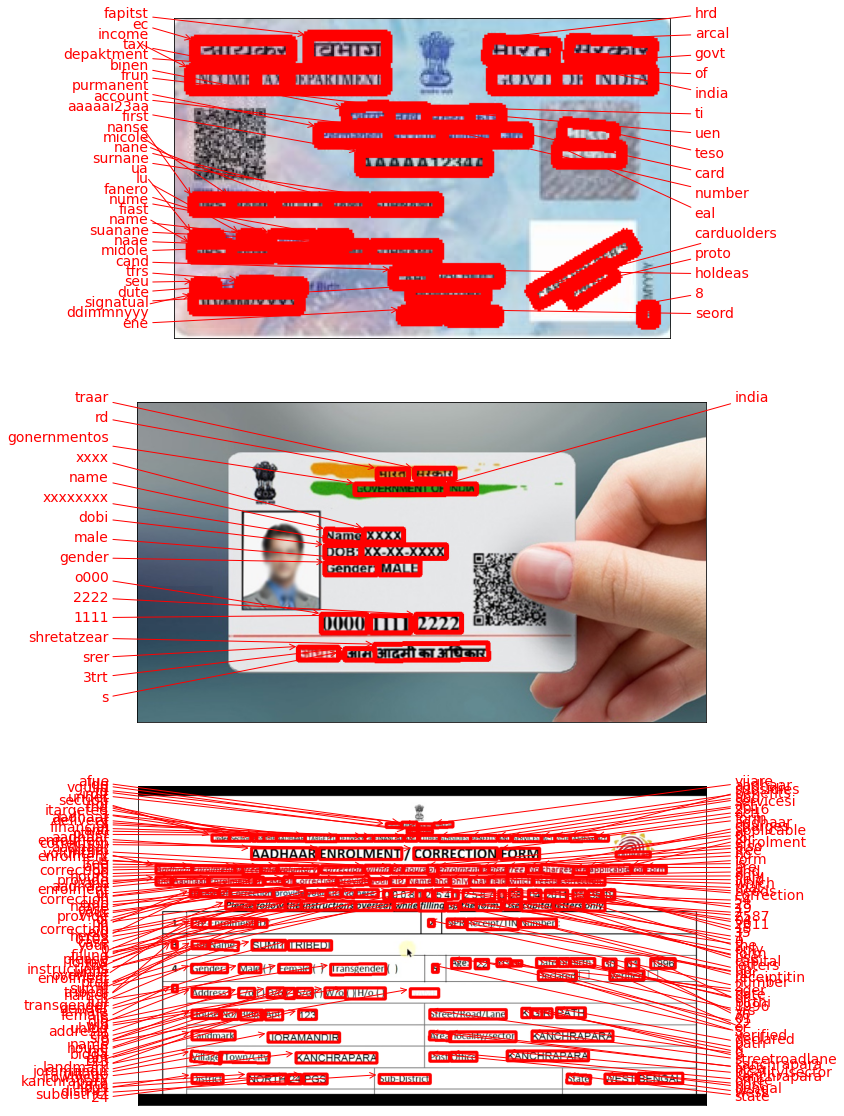

In [26]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

### A few non -working examples

### Camelot

In [16]:
import camelot
tables = camelot.read_pdf('adharapp.pdf') #, pages='all')
tables[0].df
#tables
tables[0].parsing_report
#tables.export('out.csv', f='csv', compress=True) 

{'accuracy': 0, 'whitespace': 100.0, 'order': 1, 'page': 1}

In [28]:
import pytesseract
from PIL import Image
from itertools import groupby
from functools import reduce
import numpy as np
from spacy.lang.en import English
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

nlp = English()

# schema = [u'level', u'page_num', u'block_num', u'par_num', u'line_num', u'word_num', u'left', u'top', u'width', u'height', u'conf', u'text']

LINE_INDEX = 4
CONF_INDEX = -2
WORD_INDEX = -1
LEFT_INDEX = -6
WIDTH_INDEX = -4

def processingOneLineOfWords(words, joinThreshold = 10):
    words = list(words)
    wordDistanceArr = list(map(lambda p: p[1][LEFT_INDEX] - (p[0][LEFT_INDEX] + p[0][WIDTH_INDEX]), zip(words, words[1:])))
    shouldSplitBecauseOfText = np.array(list(map(lambda w: w[WORD_INDEX][0] == '|', words[1:])))
    shouldSplitBecauseOfDistance = np.array(wordDistanceArr) > joinThreshold
    shouldSplit = list((shouldSplitBecauseOfText + shouldSplitBecauseOfDistance)>0 +0)
    phraseIds = reduce(lambda s,x: s + [x+s[-1]] , shouldSplit, [0])
    # print(phraseIds)
    wordGroups = [map(lambda p: p[0], it) for k, it in groupby(zip(words, phraseIds), lambda p: p[1])]

    return map(lambda arr: arr[0][0:WORD_INDEX] + [' '.join(map(lambda w: w[WORD_INDEX], arr))], wordGroups)

def extract_data(img_file_path):
    data = pytesseract.image_to_data(Image.open(img_file_path))
    # print(data)
    arrays = list(map(lambda s: s.split('\t'), data.split('\n')))[1:]
    words = list(map(lambda arr: arr[0:6]  + list(map(lambda i: int(i), arr[6:-1])) + [arr[-1]], arrays))
    #print(words)
    words = list(filter(lambda arr: isinstance(arr[CONF_INDEX], float) and float(arr[CONF_INDEX]) >0 and arr[WORD_INDEX], words))
    lines = [processingOneLineOfWords(map(lambda x: x, it)) for k, it in groupby(words, lambda arr: ','.join(arr[0:5]))]
    return [lines]

def extract_key_values_from_line(line):
    hasNumbers = map(lambda phrase: reduce(lambda s,t: s+t.like_num, nlp(phrase[WORD_INDEX]), 0), line)
    return filter(lambda v: v, [[line[i-1][WORD_INDEX], line[i][WORD_INDEX]] if v > 0 and not hasNumbers[i-1] else None for i, v in enumerate(hasNumbers)])

#[lines] = extract_data('/tmp/1.png')
#[lines] = extract_data('/tmp/R85K-EwL-L5FOBhgHJuTyw.png')
[lines] = extract_data('claim_form2.png')

pairs = filter(lambda l: len(l)>0, map(extract_key_values_from_line, lines))
for p in pairs:
    print(p)

### Deep Text Recognition

In [85]:
import os
os.chdir('deep-text-recognition/')
%pwd

#output = !CUDA_VISIBLE_DEVICES=0 python3 demo.py \
output = !python demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder demo_image/ \
--saved_model TPS-ResNet-BiLSTM-Attn.pth

'C:\\Work\\TCS\\aws\\ocrplusplus\\deep-text-recognition'

In [96]:
output

['Traceback (most recent call last):',
 '  File "demo.py", line 10, in <module>',
 '    from dataset import RawDataset, AlignCollate',
 '  File "C:\\Work\\TCS\\aws\\ocrplusplus\\deep-text-recognition\\dataset.py", line 9, in <module>',
 '    from natsort import natsorted',
 "ModuleNotFoundError: No module named 'natsort'"]

In [93]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
  row = row.split('\t')
  filename = row[0].strip()
  label = row[1].strip()
  conf = row[2].strip()
  img = Image.open(filename)
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

  data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
  data.loc[ind, 'id'] = filename
  data.loc[ind, 'label'] = label
  data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))

ValueError: 'image_path               \tpredicted_labels         \tconfidence score' is not in list